In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import polars as pl

lambda_arrival = 4
lambda_service = 100
num_events = 5000

interarrival_times = [0.0] + np.random.exponential(scale=1/lambda_arrival, size=num_events - 1).tolist()
work_times = np.random.exponential(scale=1/lambda_service, size=num_events).tolist()

arrival_times = np.cumsum(interarrival_times).tolist()

print(f"Arrival Times: {arrival_times}")

served_times = []
finish_times = []

busy_until = -1.0
for arrival, work_time in zip(arrival_times, work_times):
    served_time = max(arrival, busy_until)
    busy_until = served_time + work_time
    served_times.append(served_time)
    finish_times.append(busy_until)

print(f"Time service begins: {served_times}")
print(f"Time finish works: {finish_times}")
print(f"Busy until: {busy_until}")

current_time = 0
num_customer_serving = []
num_customer_waiting = []
num_customer_sys = []
time_step=0.1
num_samples = int(busy_until/time_step)
print(f"Sample {num_samples} times")

for _ in range(num_samples):
    serving = sum(served_time <= current_time < served_time + work for (served_time, work) in zip(served_times, work_times))
    waiting = sum(arrival <= current_time and served_time > current_time for (arrival, served_time) in zip(arrival_times, served_times))
    
    num_customer_serving.append(serving)
    num_customer_waiting.append(waiting)
    num_customer_sys.append(serving + waiting)

    current_time += time_step

Arrival Times: [0.0, 0.21428868281455404, 0.7267219048410106, 0.9277857358335466, 0.9646555254359587, 1.3046217726701126, 1.4915934908995119, 1.5780268059173346, 1.9276923040591163, 1.972662755698996, 2.2437489758801377, 2.3840782253101906, 2.4323088582665404, 2.4683271276330525, 3.101293427008127, 3.36173493669329, 3.41049490588622, 3.831922777650907, 3.844088571630151, 3.932443430941941, 4.276743151008591, 4.3578921830022335, 4.468549721508795, 4.491042868833372, 4.579942129163423, 4.628864833516469, 5.059133694200323, 5.337716167930854, 5.674042617623226, 5.905118358794747, 6.047859939101413, 6.1474483459538, 6.543304525423628, 7.323309733397259, 7.443552883288915, 7.469739849818489, 7.5244173248785255, 8.093500494685985, 8.337740837033012, 8.830937568238086, 8.922805250978831, 9.072570238291245, 9.340825390576244, 9.4347643092776, 9.563105938536964, 9.907812623899268, 10.346811745025324, 10.438059375070969, 11.40185181294268, 11.49615171130638, 12.254078242365864, 12.72626143220228

In [3]:
times_wait_queue = [s_time - a_time for s_time, a_time in zip(served_times, arrival_times)]
times_in_sys = [q_t + (f_t - s_t) for q_t, f_t, s_t in zip(times_wait_queue, finish_times, served_times)]
idle_times = [served_times[i] - finish_times[i-1] for i in range(len(served_times)) if i!=0]

average_wait_queue = sum(times_wait_queue)/num_events
average_service_time = sum(work_times)/num_events
average_time_interarr = sum(interarrival_times)/(num_events - 1)
average_wait_per_wait = sum(times_wait_queue)/sum(num_customer_waiting)
average_sys_time = sum(times_in_sys)/num_events
p_wait = sum(num_customer_waiting)/num_events
p_idle = sum(idle_times)/num_samples

p_idle

0.09604905343887765

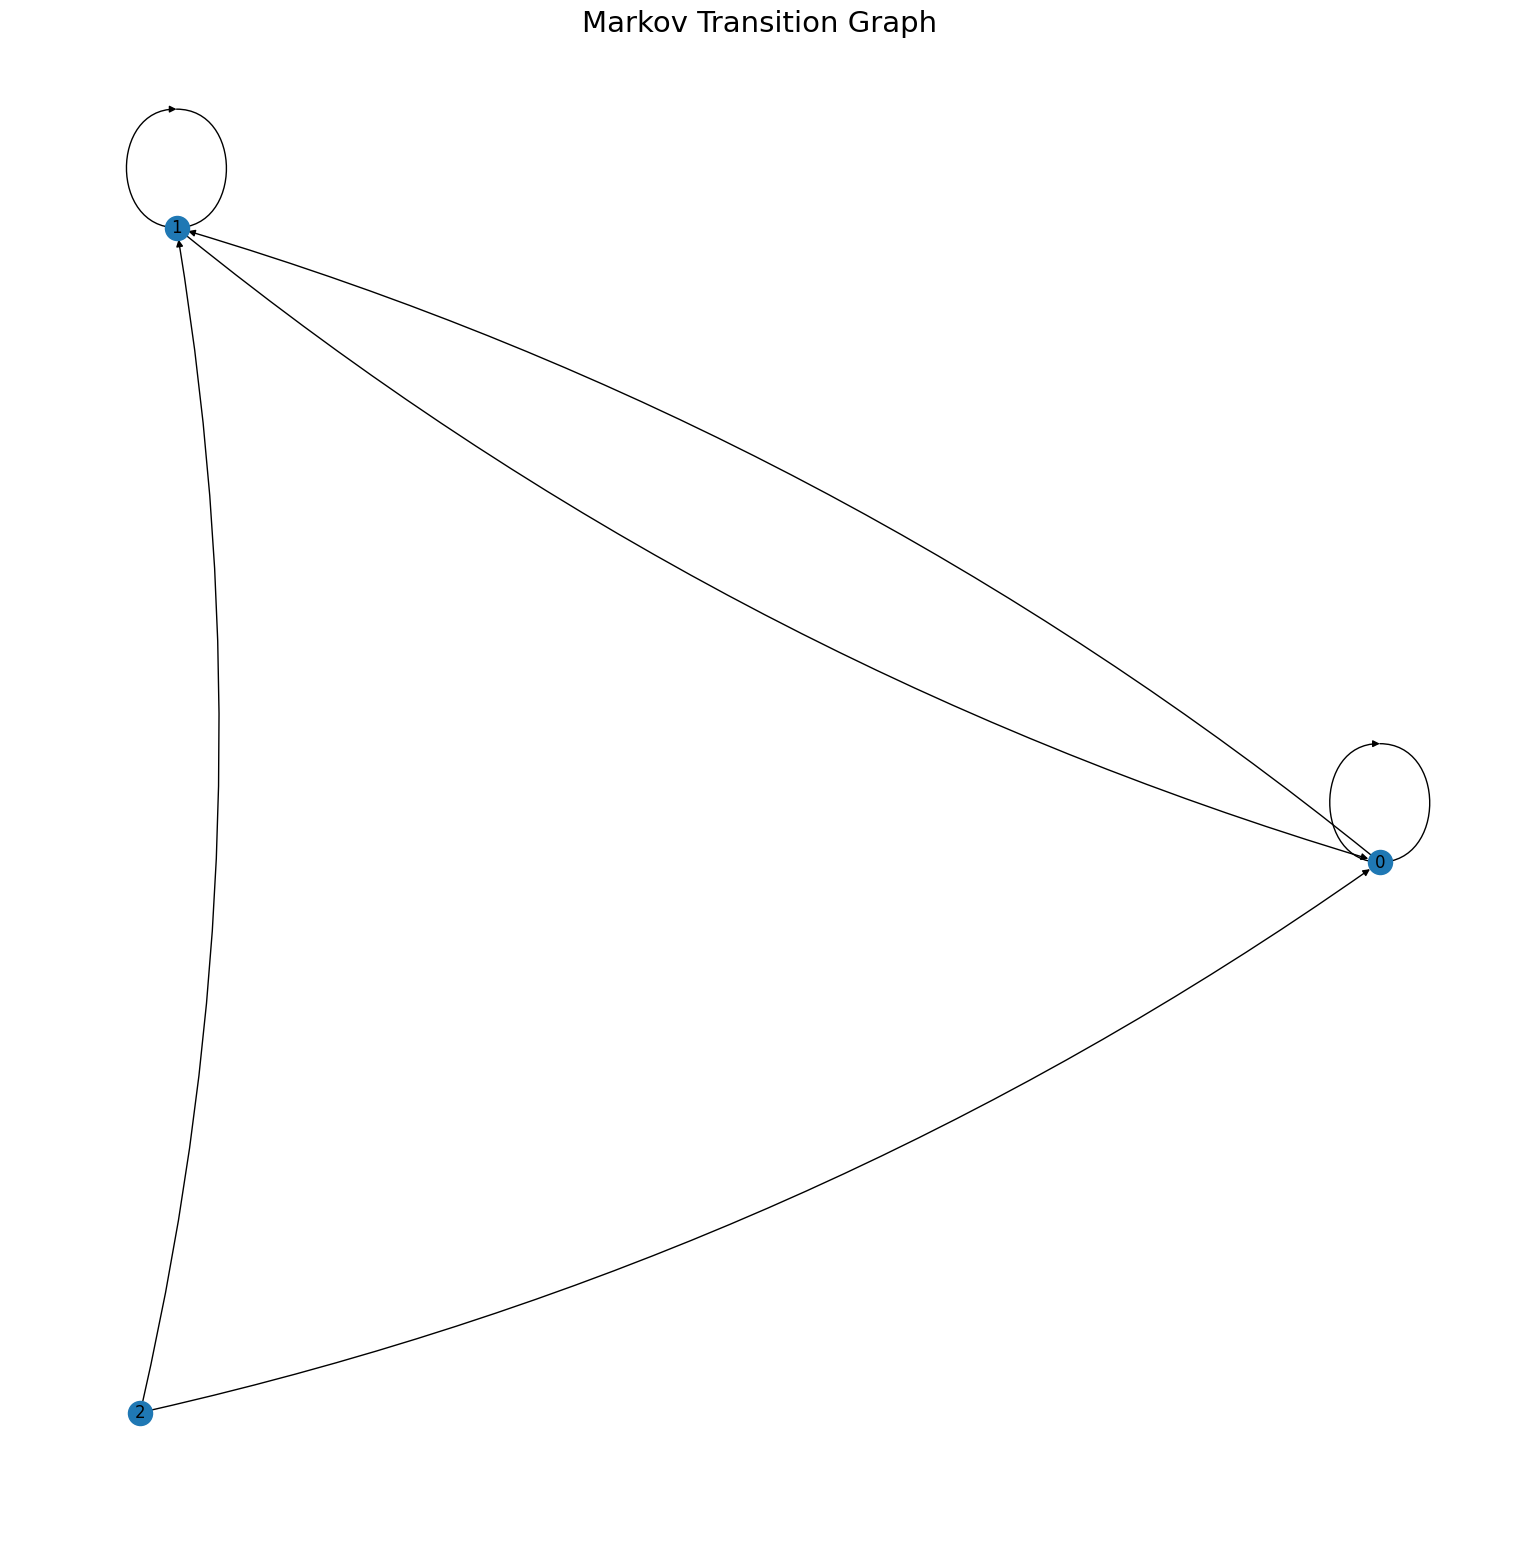

In [4]:
class MG1:
    def __init__(self, seq):
        self.seq = seq

    @property
    def seq(self):
        return self._seq
    
    @property
    def graph(self):
        def round_markov_graph(graph, decimals=2):
            factor = 10 ** decimals
            new_graph = {}

            for node, transitions in graph.items():
                rounded_transitions = {k: round(v * factor) for k, v in transitions.items()}
                total = sum(rounded_transitions.values())
                diff = factor - total

                if diff != 0:
                    max_key = max(rounded_transitions, key=rounded_transitions.get)
                    rounded_transitions[max_key] += diff

                final_transitions = {k: v / factor for k, v in rounded_transitions.items() if v > 0}

                if final_transitions:
                    new_graph[node] = final_transitions
            return new_graph

        return round_markov_graph(self._graph)
    
    @seq.setter
    def seq(self, new_seq):
        if not isinstance(new_seq, (list, str)):
            raise ValueError("Sequence must be a list or string.")
        if len(new_seq) < 2:
            raise ValueError("Sequence must have at least 2 elements.")
        self._seq = new_seq
        self._graph = self.__fit()
        self._vocab = sorted(set(self._seq))
    
    def __fit(self):
        dict_seq = {}
        def process_seq(seq):
            for state in seq:
                dict_seq[state] = {}
            for i in range(len(seq) -1):
                if seq[i+1] not in dict_seq[seq[i]]:
                    dict_seq[seq[i]][seq[i+1]] = 1
                else:
                    dict_seq[seq[i]][seq[i+1]] += 1
            return dict_seq
        def cal_markov(dict_seq):
            for key in dict_seq:
                total = sum(dict_seq[key].values())
                for key2 in dict_seq[key]:
                    dict_seq[key][key2] /= total
            return dict_seq
        
        return cal_markov(process_seq(self._seq))
    
    def draw(self, fgsz=10, layout='spring'):
        from netgraph import Graph

        G = nx.DiGraph()
        for start_node, value in self.graph.items():
            for end_node, weight in value.items():
                G.add_edge(start_node, end_node, label=weight)

        if layout == 'spring':
            pos = nx.spring_layout(G, k=1.2)
        elif layout == 'kamada':
            pos = nx.kamada_kawai_layout(G)
        elif layout == 'circular':
            pos = nx.circular_layout(G)
        else:
            raise ValueError("Layout must be 'spring', 'kamada', or 'circular'")

        plt.figure(figsize=(fgsz, fgsz))     
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw(G, pos = pos, connectionstyle="arc3,rad=0.1", with_labels=True)

        plt.title("Markov Transition Graph", fontsize=14 * (fgsz / 10))
        plt.show()
    
    @property
    def trans_matrix(self):
        data = [(src, dst, prob) for src, trans in self.graph.items() for dst, prob in trans.items()]
        df = pl.DataFrame(data, schema=["state_from", "state_to", "prob"], orient="row")
        return df.pivot(values="prob", index="state_to", on="state_from", aggregate_function="first").fill_null(0)
    
mg = MG1(num_customer_sys)
mg.draw(15)

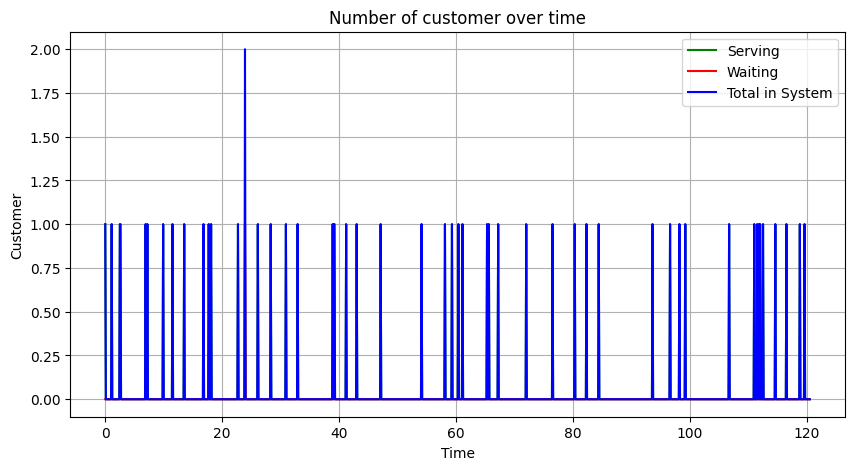

In [9]:
time_points = np.arange(0, num_samples * time_step, time_step)

plt.figure(figsize=(10, 5))
plt.plot(time_points, num_customer_serving, label="Serving", color='g')
plt.plot(time_points, num_customer_waiting, label="Waiting", color='r')
plt.plot(time_points, num_customer_sys, label="Total in System", color='b')
plt.xlabel("Time")
plt.ylabel("Customer")
plt.title("Number of customer over time")
plt.legend()
plt.grid()
plt.show()